In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance


# Load Data:
fetal_health_raw = pd.read_csv('/content/sample_data/fetal_health.csv')
fetal_health_raw.head()


,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [78]:
# Data Cleaning:
fetal_health_raw.info()
ead_columns = ['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions', 'light_decelerations', 'severe_decelerations', 'prolongued_decelerations', 'abnormal_short_term_variability', 'mean_value_of_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'mean_value_of_long_term_variability', 'fetal_health']
fetal_health_data = fetal_health_raw[ead_columns]
fetal_health_data.head()
fetal_health_data_cleaned = fetal_health_data.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

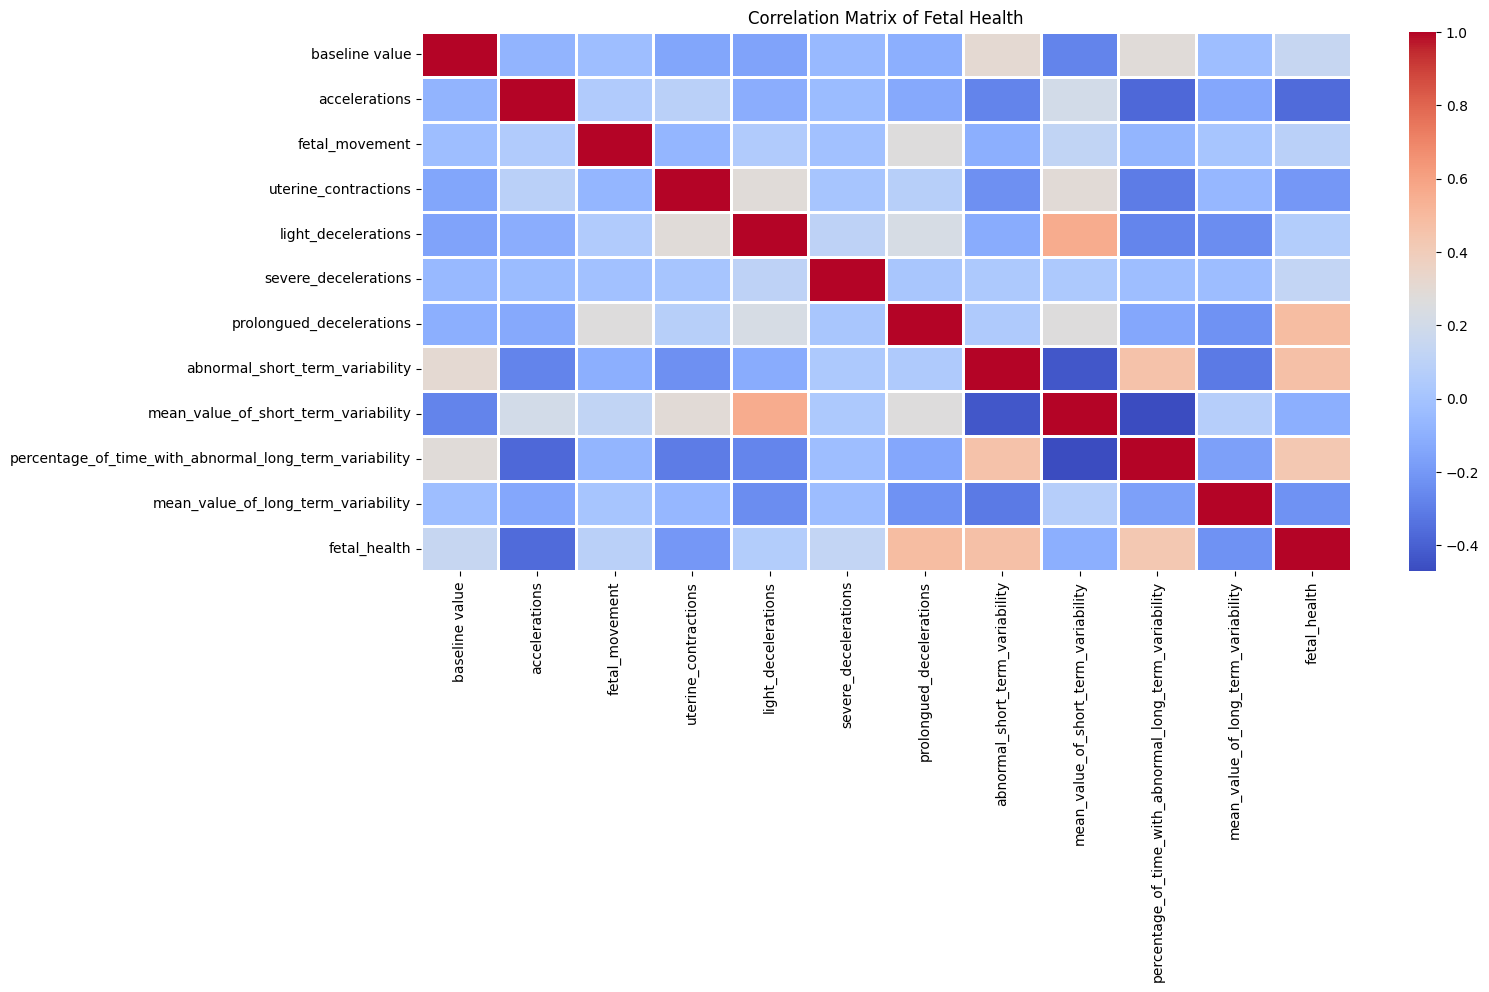

In [79]:
# Data Understanding:

corr= fetal_health_data_cleaned.corr()
plt.figure(figsize=(15, 7))

sns.heatmap(corr, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.8)

plt.title("Correlation Matrix of Fetal Health")
plt.show()

In [80]:
# Split Training and Testing Dataset:
X = fetal_health_data_cleaned.drop('fetal_health', axis = 1)
y = fetal_health_data_cleaned['fetal_health']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



In [81]:
# Create different types of base models and get MSE

linear_reg = LinearRegression()
knn_reg = KNeighborsRegressor()
tree_reg = DecisionTreeRegressor(random_state=42)
svr_reg = SVR()

# Create pipelines for each regressor
pipelines = {
    'linear': Pipeline([('scaler', StandardScaler()), ('regressor', linear_reg)]),
    'knn': Pipeline([('scaler', StandardScaler()), ('regressor', knn_reg)]),
    'tree': Pipeline([('regressor', tree_reg)]),
    'svr': Pipeline([('scaler', StandardScaler()), ('regressor', svr_reg)])
}

voting_reg = VotingRegressor(estimators=[
    ('linear', pipelines['linear']),
    ('knn', pipelines['knn']),
    ('tree', pipelines['tree']),
    ('svr', pipelines['svr'])
])

# Other Regression Models
results_mse = {}
results_coef = {}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    pipeline_pred = pipeline.predict(X_test)
    pipeline_mse = mean_squared_error(y_test, pipeline_pred)
    results_mse[name] = pipeline_mse
    if name == 'linear':
      results_coef[name] = pipeline.named_steps['regressor'].coef_
    elif name == 'tree':
      results_coef[name] = pipeline.named_steps['regressor'].feature_importances_
    else:
      results_coef[name] = pipeline

# Evaluate Voting Regressor
voting_reg.fit(X_train, y_train)
voting_pred = voting_reg.predict(X_test)
voting_mse = mean_squared_error(y_test, voting_pred)
results_mse['voting'] = voting_mse

# Evaluate GradientBoosting Classifier
gradientBoostingClf = GradientBoostingClassifier(n_estimators= 1000, max_depth=1)
gradientBoostingClf.fit(X_train, y_train)
gradientBoostingClf_Preds = gradientBoostingClf.predict(X_test)
gradientBoostingClf_mse = mean_squared_error(y_test, gradientBoostingClf_Preds)
results_mse['gradientBoosting'] = gradientBoostingClf_mse
results_coef['gradientBoosting'] = gradientBoostingClf

print(results_mse)


{'linear': 0.154588239516574, 'knn': 0.08526315789473685, 'tree': 0.10338345864661654, 'svr': 0.0915568947805403, 'voting': 0.07486250119008296, 'gradientBoosting': 0.10338345864661654}


In [82]:
# Understand Feature Coefficents from each base model:
print("\nCoefficients from Linear Regression:")
linear_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': results_coef['linear']})
linear_df = linear_df.sort_values(by='coefficient', ascending=False)
print(linear_df)


print("\nFeature Importance from Decision Tree:")
tree_df = pd.DataFrame({'feature': X_train.columns, 'importance': results_coef['tree']})
tree_df = tree_df.sort_values(by='importance', ascending=False)
print(tree_df)


print("\nPermutation Importance from KNN:")
result_knn = permutation_importance(results_coef['knn'], X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
knn_df = pd.DataFrame({'feature': X_test.columns, 'importance': result_knn.importances_mean})
knn_df = knn_df.sort_values(by='importance', ascending=False)
print(knn_df)


print("\nPermutation Importance from SVR:")
result_svr = permutation_importance(results_coef['svr'], X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
svr_df = pd.DataFrame({'feature': X_test.columns, 'importance': result_svr.importances_mean})
svr_df = svr_df.sort_values(by='importance', ascending=False)
print(svr_df)


print("\nPermutation Importance from GradientBoostingClassifier:")
result_gbc = permutation_importance(results_coef['gradientBoosting'], X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
gbc_df = pd.DataFrame({'feature': X_test.columns, 'importance': result_gbc.importances_mean})
gbc_df = gbc_df.sort_values(by='importance', ascending=False)
print(gbc_df)


Coefficients from Linear Regression:
                                              feature  coefficient
6                            prolongued_decelerations     0.302719
9   percentage_of_time_with_abnormal_long_term_var...     0.204519
7                     abnormal_short_term_variability     0.178923
5                                severe_decelerations     0.073338
8                mean_value_of_short_term_variability     0.062599
4                                 light_decelerations     0.028927
0                                      baseline value     0.024956
10                mean_value_of_long_term_variability     0.005502
2                                      fetal_movement     0.003594
3                                uterine_contractions    -0.060134
1                                       accelerations    -0.061757

Feature Importance from Decision Tree:
                                              feature  importance
7                     abnormal_short_term_variabilit

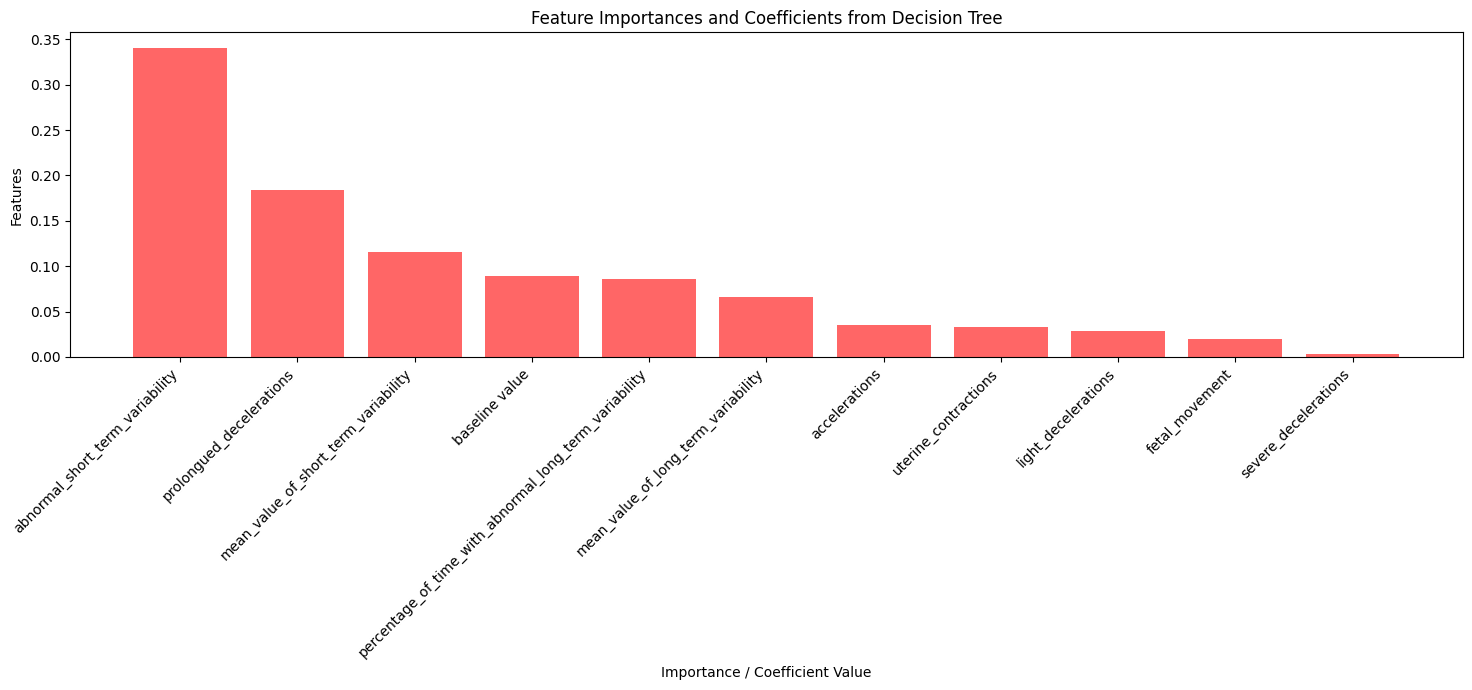

<Figure size 640x480 with 0 Axes>

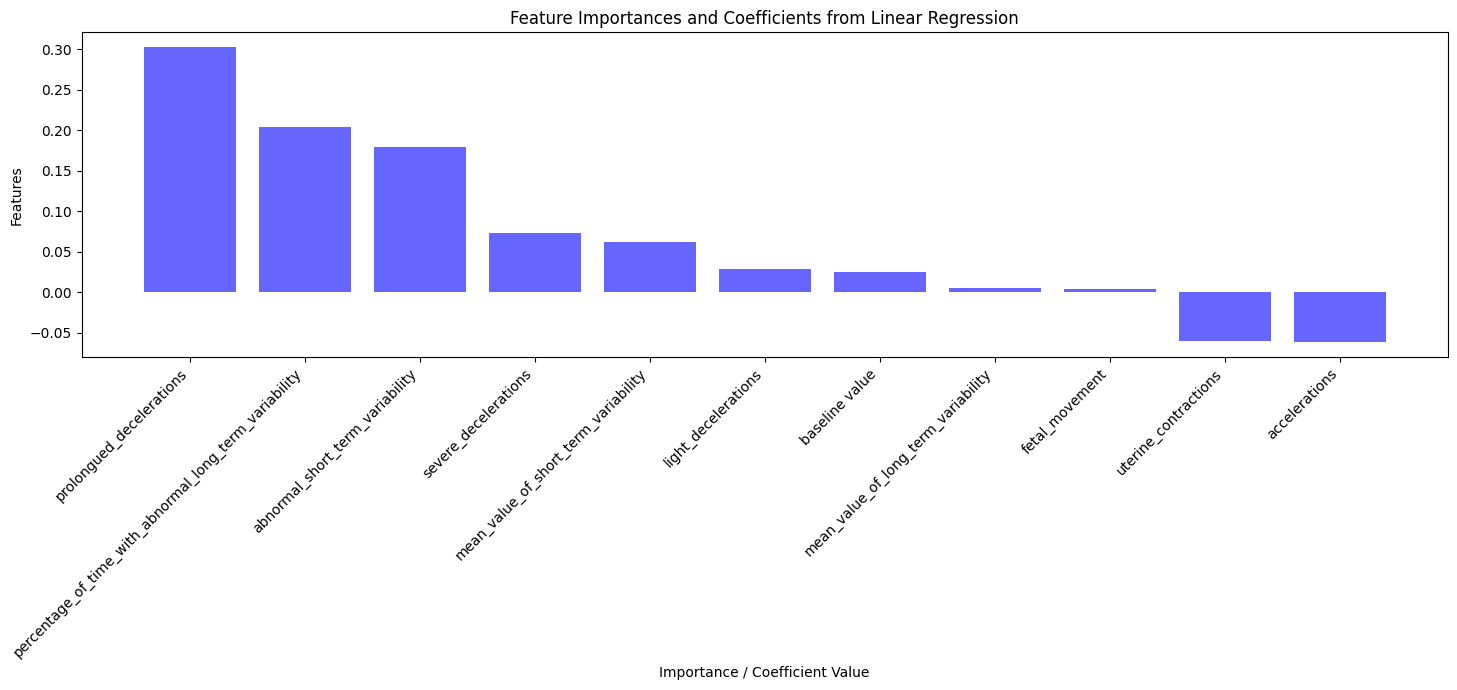

<Figure size 640x480 with 0 Axes>

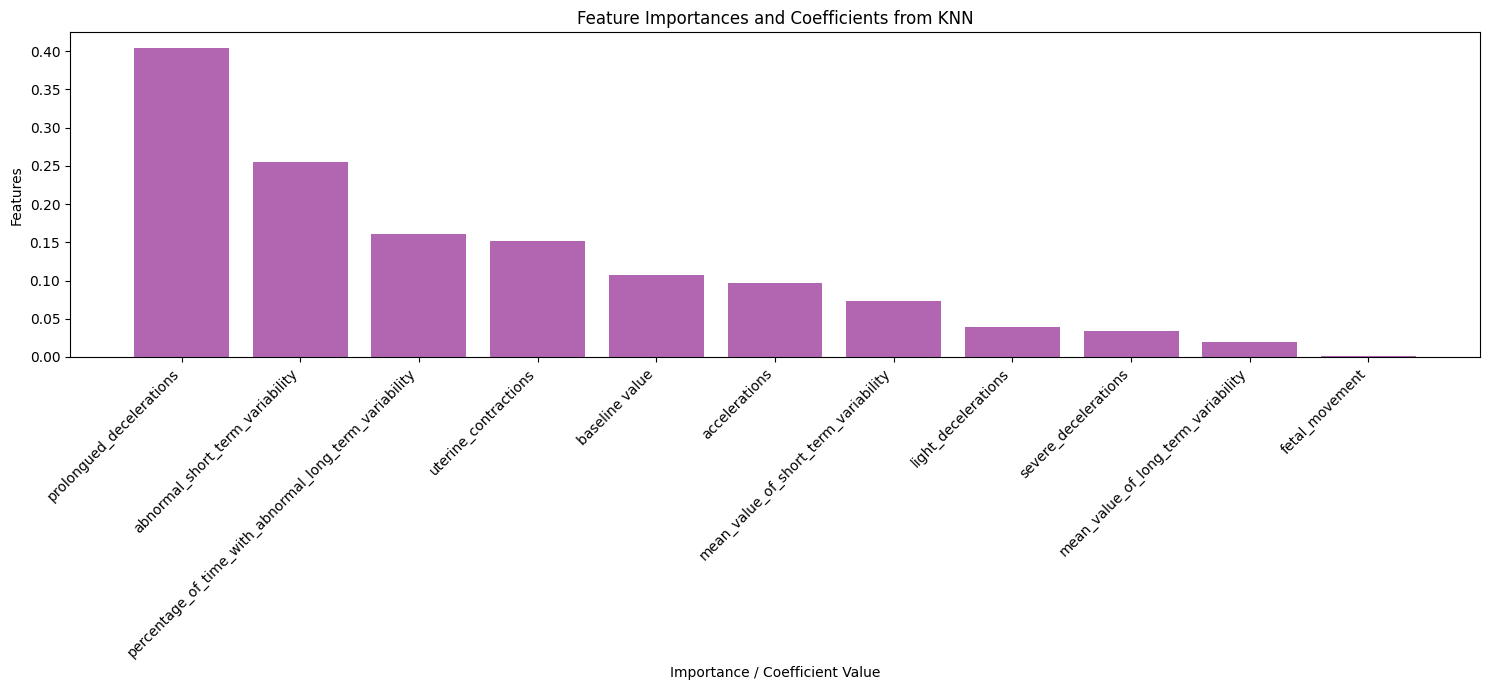

<Figure size 640x480 with 0 Axes>

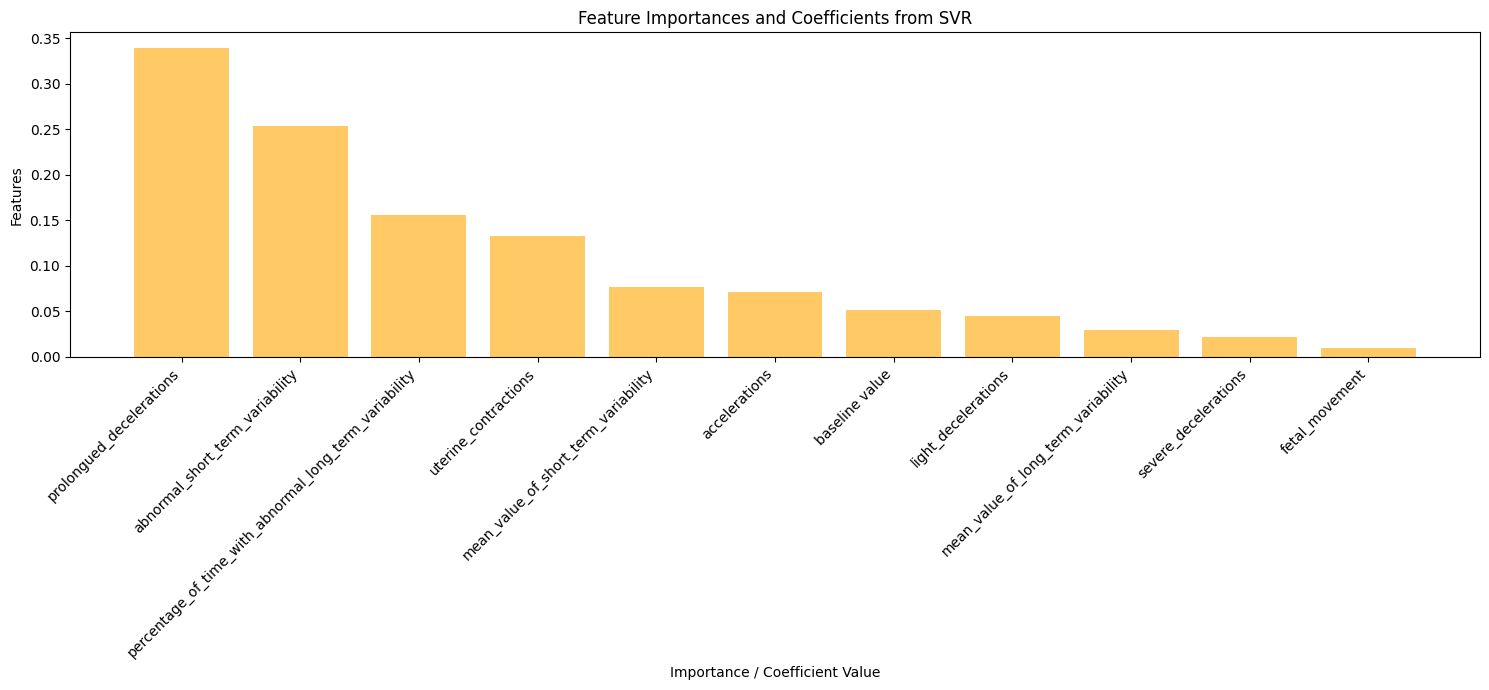

<Figure size 640x480 with 0 Axes>

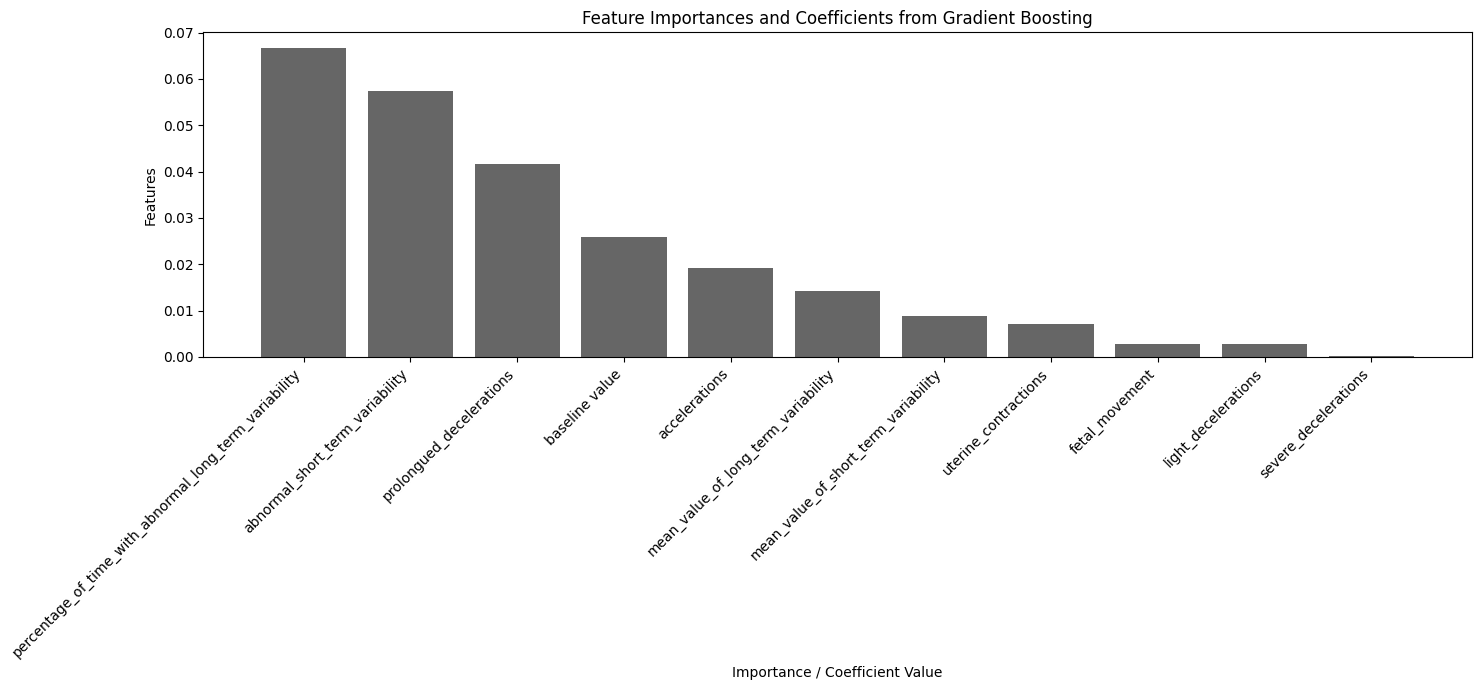

<Figure size 640x480 with 0 Axes>

In [84]:
# Graph Visulization for each base model
plt.figure(figsize=(15, 7))
plt.bar(tree_df['feature'], tree_df['importance'], color='red', alpha=0.6)

plt.xlabel('Importance / Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importances and Coefficients from Decision Tree')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.savefig("/content/sample_data/tree.png")


plt.figure(figsize=(15, 7))
plt.bar(linear_df['feature'], linear_df['coefficient'], color='blue', alpha=0.6)
plt.xlabel('Importance / Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importances and Coefficients from Linear Regression')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.savefig("/content/sample_data/linear.png")


plt.figure(figsize=(15, 7))
plt.bar(knn_df['feature'], knn_df['importance'], color='purple', alpha=0.6)
plt.xlabel('Importance / Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importances and Coefficients from KNN')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.savefig("/content/sample_data/knn.png")


plt.figure(figsize=(15, 7))
plt.bar(svr_df['feature'], svr_df['importance'], color='orange', alpha=0.6)
plt.xlabel('Importance / Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importances and Coefficients from SVR')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.savefig("/content/sample_data/svr.png")


plt.figure(figsize=(15, 7))
plt.bar(gbc_df['feature'], gbc_df['importance'], color='black', alpha=0.6)
plt.xlabel('Importance / Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importances and Coefficients from Gradient Boosting')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.savefig("/content/sample_data/gbc.png")
